In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import skimage.morphology
import cv2

In [2]:
robot_frame_filenames = set([fname.split("_")[0] 
                             for fname in glob.glob("robotframes/*")])
habitat_frame_filenames = set([fname.split("_")[0] 
                               for fname in glob.glob("habitatframes/*")])
robot_frame_processed_filenames = set([fname.split("_")[0] 
                                       for fname in glob.glob("robotframesprocessed/*")])

### What is the visual domain gap for depth?

1. Habitat depth frames are perfect within the (min depth, max depth) range, points closer than min depth are set to min depth, points further than max depth are set to max depth
2. We can replicate the thresholding in robot depth frames, but robot depth frames are zero in regions with high uncertainty (e.g., object boundaries) — this is the main domain gap — and likely noisy when nonzero (how exactly to characterize this noise?)

In [3]:
def object_boundaries(rgb):
    edges = cv2.Canny(image=rgb, threshold1=100, threshold2=200)
    edges = cv2.dilate(edges, skimage.morphology.disk(10)) 
    edges = edges - cv2.dilate(edges, skimage.morphology.disk(1))
    edges = cv2.dilate(edges, skimage.morphology.disk(10))
    return edges

def visualize(fname, min_depth=0.5, max_depth=4.0):
    rgb = np.load(f"{fname}_rgb.npy")
    depth = np.load(f"{fname}_depth.npy")
    depth = np.where(
        depth > 0,
        np.clip(depth, min_depth, max_depth),
        depth
    )
    edges = object_boundaries(rgb)
    
    _, subplots = plt.subplots(1, 6, figsize=(15, 4))
    
    subplots[0].imshow(rgb)
    subplots[0].set_axis_off()
    subplots[1].imshow(depth)
    subplots[1].set_axis_off()
    
    subplots[2].imshow(depth == min_depth)
    subplots[2].set_axis_off()
    subplots[3].imshow(depth == max_depth)
    subplots[3].set_axis_off()
    
    subplots[4].imshow(depth == 0)
    subplots[4].set_axis_off()
    subplots[5].imshow(edges)
    subplots[5].set_axis_off()
    
    plt.show()
    
    print(f"Depth range: ({depth[depth != 0].min()}, {depth.max()})")
    print("_" * 40)

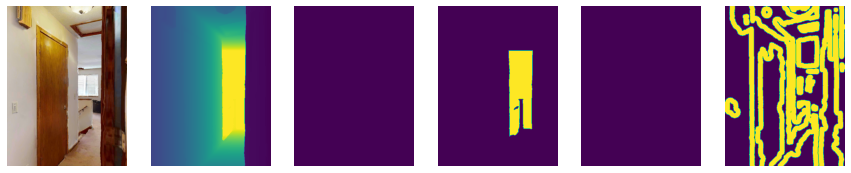

Depth range: (0.5376867055892944, 4.0)
________________________________________


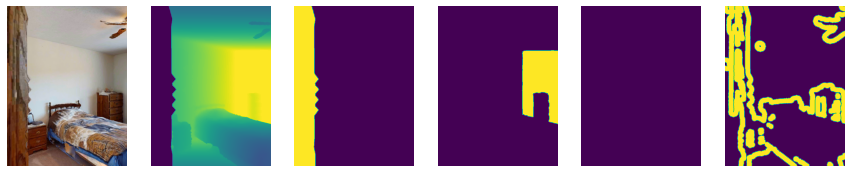

Depth range: (0.5, 4.0)
________________________________________


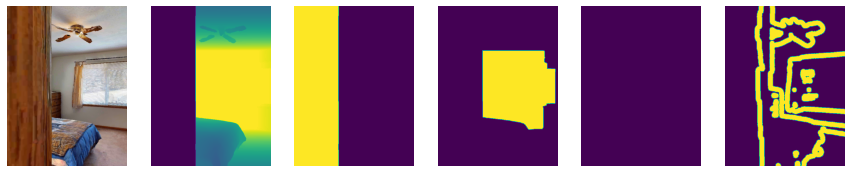

Depth range: (0.5, 4.0)
________________________________________


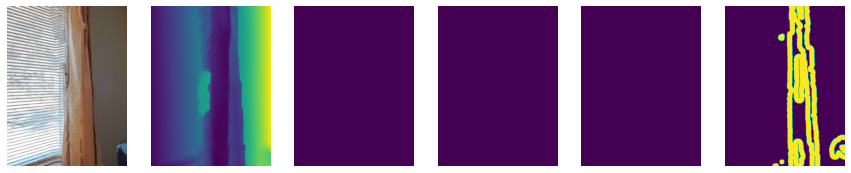

Depth range: (0.8741726875305176, 1.485736608505249)
________________________________________


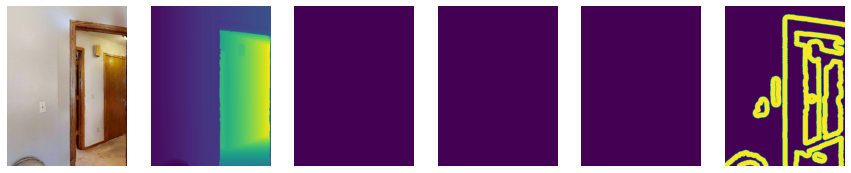

Depth range: (1.1144134998321533, 3.577343702316284)
________________________________________


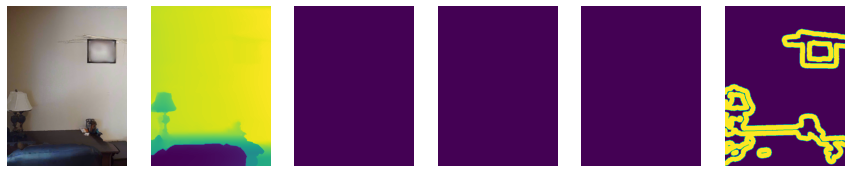

Depth range: (0.5991880297660828, 1.8661028146743774)
________________________________________


In [4]:
for fname in habitat_frame_filenames:
    visualize(fname)

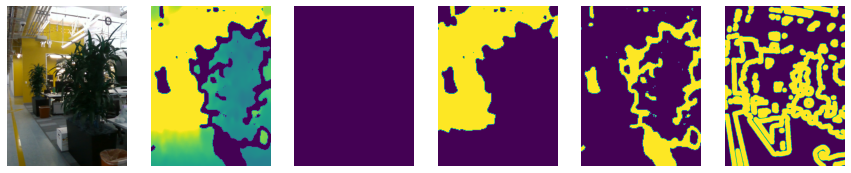

Depth range: (1.609, 4.0)
________________________________________


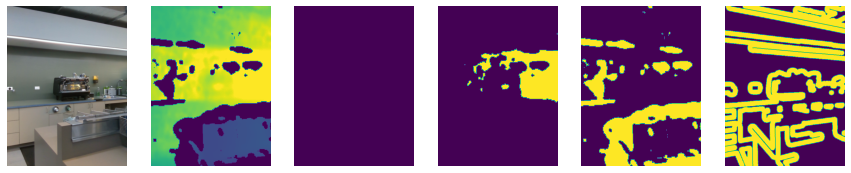

Depth range: (0.827, 4.0)
________________________________________


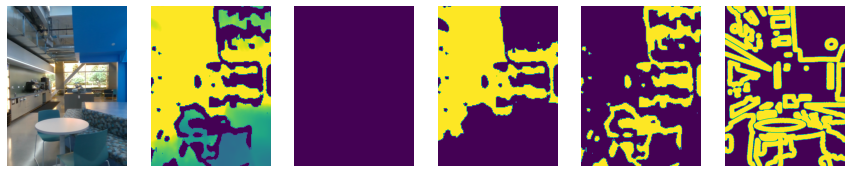

Depth range: (1.424, 4.0)
________________________________________


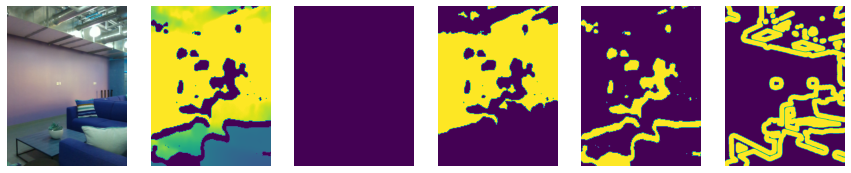

Depth range: (1.128, 4.0)
________________________________________


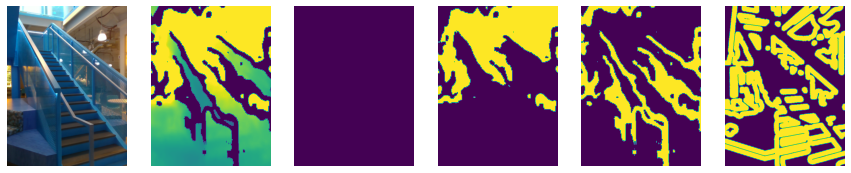

Depth range: (1.444, 4.0)
________________________________________


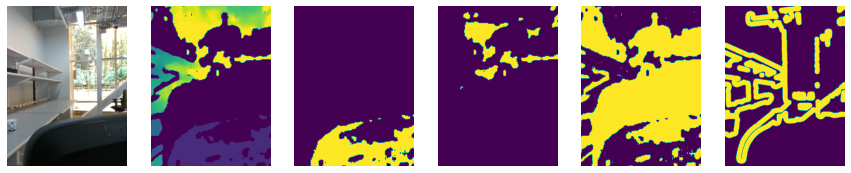

Depth range: (0.5, 4.0)
________________________________________


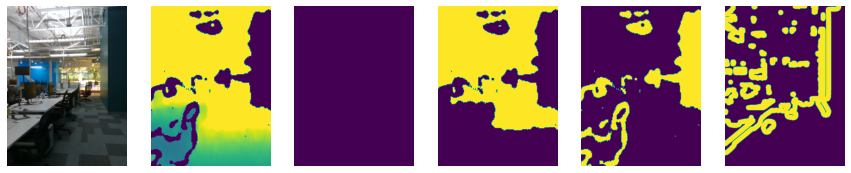

Depth range: (1.532, 4.0)
________________________________________


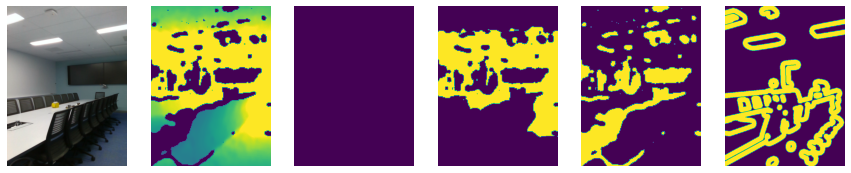

Depth range: (1.342, 4.0)
________________________________________


In [5]:
for fname in robot_frame_filenames:
    visualize(fname)

### Attempts to close the depth gap

1. Set depth to zero at object boundaries on Habitat frames
2. Fill holes in robot frames

In [12]:
def visualize_habitat_frames_with_holes(fname, min_depth=0.5, max_depth=4.0):
    rgb = np.load(f"{fname}_rgb.npy")
    depth = np.load(f"{fname}_depth.npy")
    edges = object_boundaries(rgb)
    modified_depth = depth.copy()
    modified_depth[edges == 1] = 0
    
    _, subplots = plt.subplots(1, 4, figsize=(15, 4))
    
    subplots[0].imshow(rgb)
    subplots[0].set_axis_off()
    subplots[1].imshow(depth)
    subplots[1].set_axis_off()
    subplots[2].imshow(edges)
    subplots[2].set_axis_off()
    subplots[3].imshow(modified_depth)
    subplots[3].set_axis_off()
    
    plt.show()

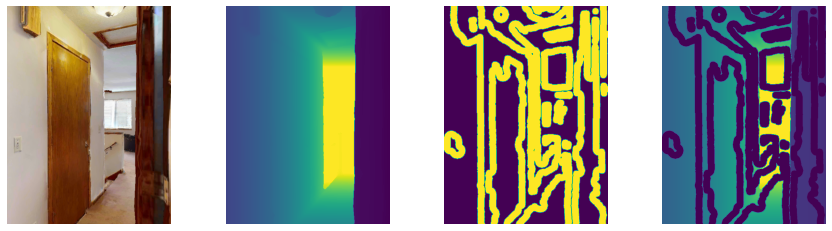

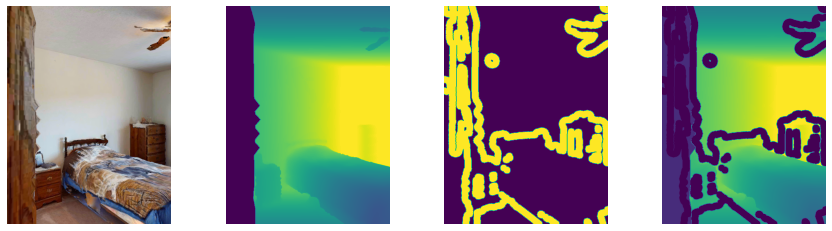

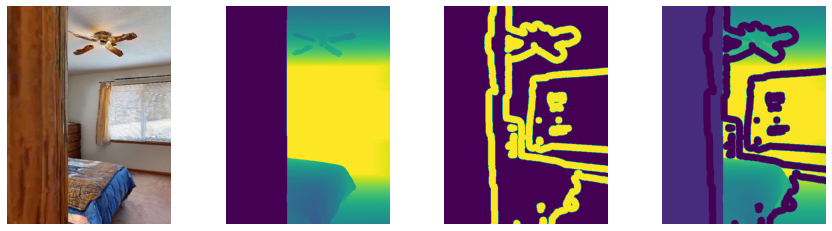

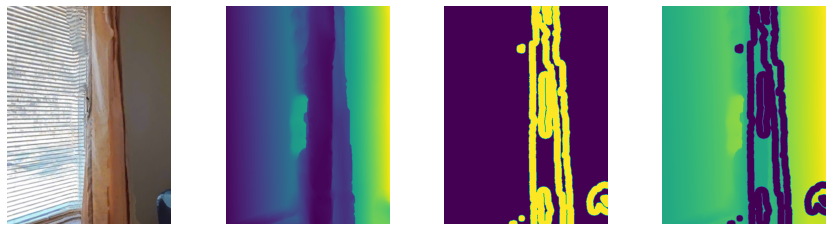

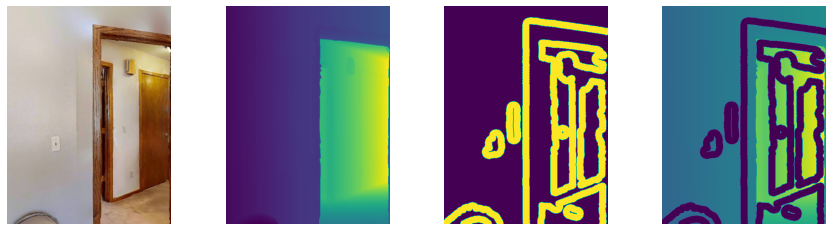

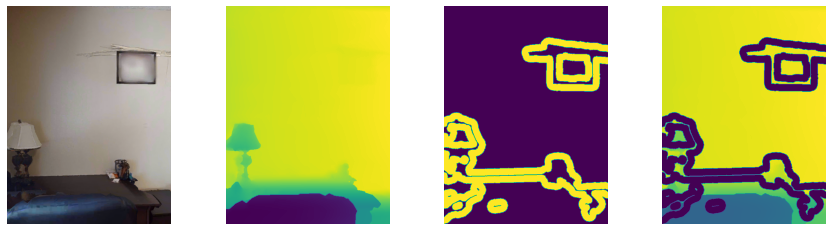

In [13]:
for fname in habitat_frame_filenames:
    visualize_habitat_frames_with_holes(fname)

In [53]:
def visualize(fname, min_depth=0.5, max_depth=4.0):
    rgb = np.load(f"{fname}_rgb.npy")
    depth = np.load(f"{fname}_depth.npy")
    depth = np.where(
        depth > 0,
        np.clip(depth, min_depth, max_depth),
        depth
    )
    edges = object_boundaries(rgb)
    
    _, subplots = plt.subplots(1, 6, figsize=(15, 4))
    
    subplots[0].imshow(rgb)
    subplots[0].set_axis_off()
    subplots[1].imshow(depth)
    subplots[1].set_axis_off()
    
    subplots[2].imshow(depth == min_depth)
    subplots[2].set_axis_off()
    subplots[3].imshow(depth == max_depth)
    subplots[3].set_axis_off()
    
    subplots[4].imshow(depth == 0)
    subplots[4].set_axis_off()
    subplots[5].imshow(edges)
    subplots[5].set_axis_off()
    
    plt.show()
    
    print(f"Depth range: ({depth[depth != 0].min()}, {depth.max()})")
    print("_" * 40)


def visualize_robot_frames_with_holes_filled(fname, min_depth=0.5, max_depth=4.0):
    # https://intelrealsense.github.io/librealsense/python_docs/_generated/pyrealsense2.hole_filling_filter.html
    depth0 = np.load(f"{fname}_depth0.npy")  # fill from left
    depth1 = np.load(f"{fname}_depth1.npy")  # farest from around
    depth2 = np.load(f"{fname}_depth2.npy")  # nearest from around => best qualitatively
    
    for depth in [depth0, depth1, depth2]:
        _, subplots = plt.subplots(1, 4, figsize=(15, 4))
        depth = np.where(
            depth > 0,
            np.clip(depth, min_depth, max_depth),
            depth
        )
        subplots[0].imshow(depth)
        subplots[0].set_axis_off()
        subplots[1].imshow(depth == min_depth)
        subplots[1].set_axis_off()
        subplots[2].imshow(depth == max_depth)
        subplots[2].set_axis_off()
        subplots[3].imshow(depth == 0)
        subplots[3].set_axis_off()
    
        plt.show()
    
    print("_" * 40)

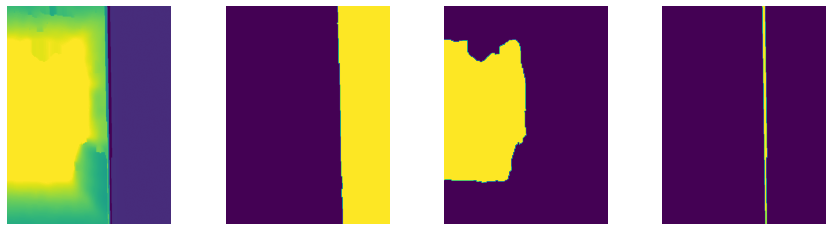

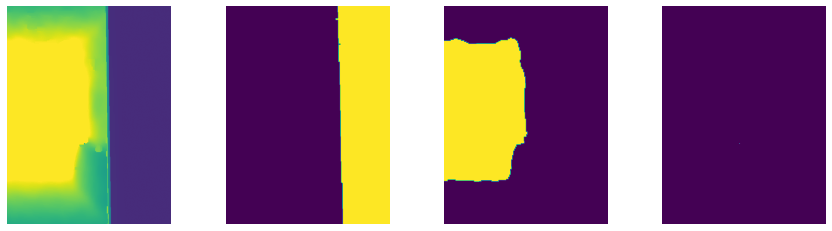

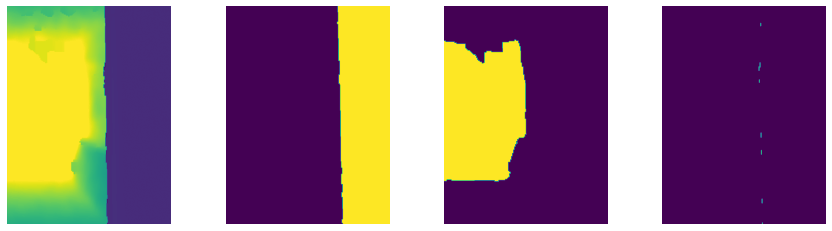

________________________________________


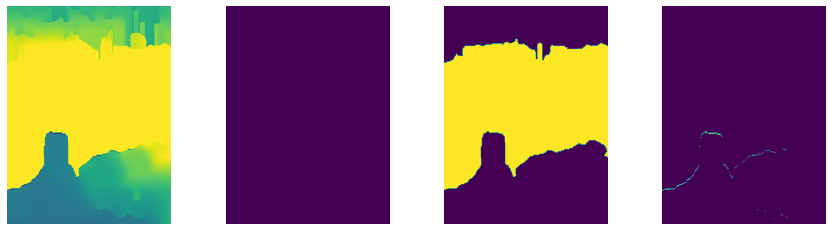

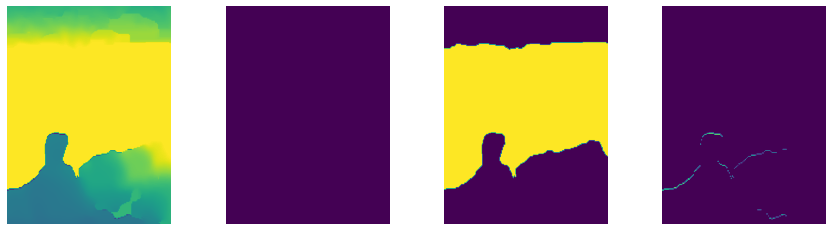

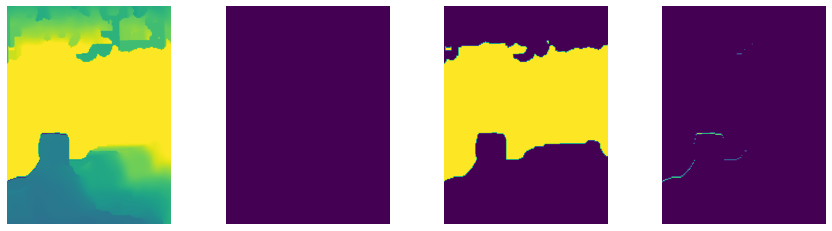

________________________________________


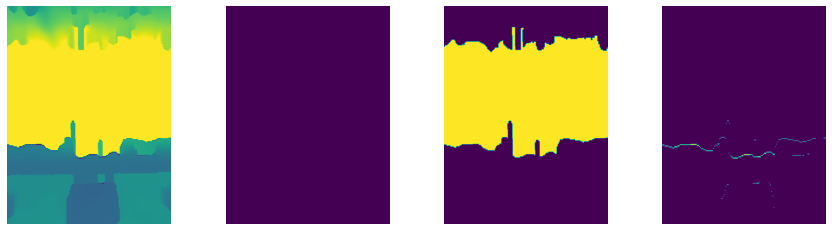

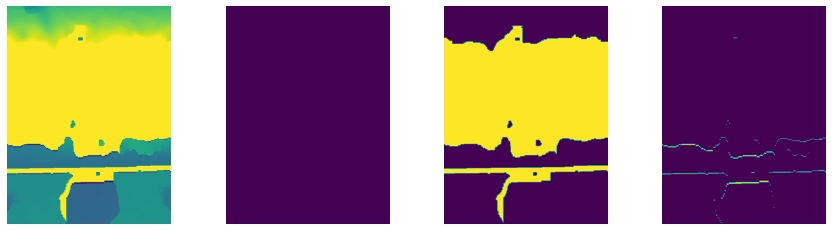

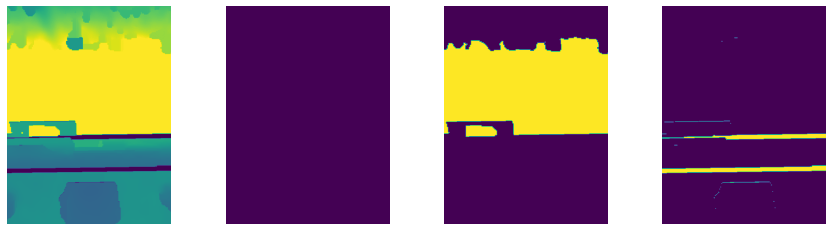

________________________________________


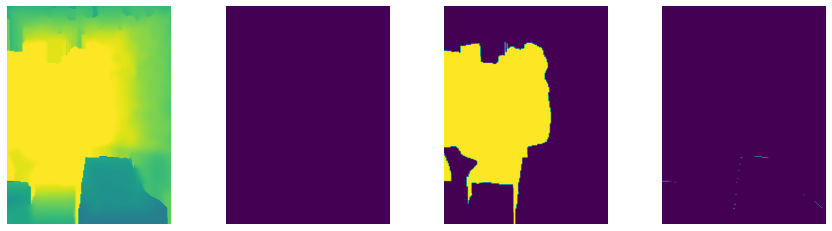

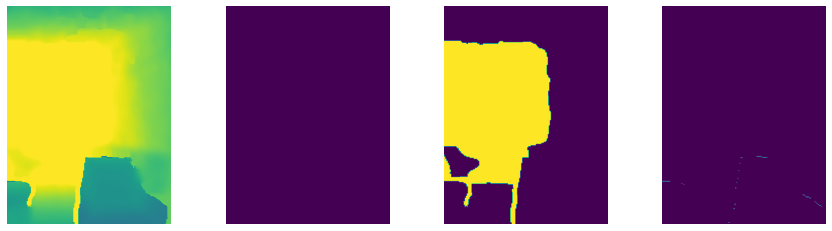

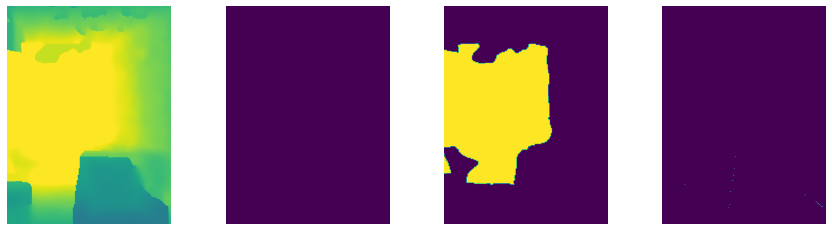

________________________________________


In [55]:
for fname in robot_frame_processed_filenames:
    visualize_robot_frames_with_holes_filled(fname)